# Predicting Radar Signals on a Honda Pilot

This notebook contains the code that was run in order to decode the radar signals on a Honda Pilot. 

An LSTM was trained on Toyota Radar Data, and Honda messages were scored based on the LSTM's prediction of radar-related information on the Honda messages.

# Run these cells to import and set up variables

You must have the CAN messages from the Honda vehicle in the data folder. Replace csv_paths_honda below or place those files into your directory.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# important! this will break plots on some windows running jupyter notebook - jupyter lab must be used instead
from utils import *
# gets these functions: 
# plot_message_id, mask_hex_str, hex_to_binary, describe_known_signal, calculate_function_metrics, greedy_search_message_id,
# get_message_id_length, select_arbitrary_bit_greedy

import pickle

csv_paths_honda = [
    "data/2020-09-18-11-36-54_5FNYF6H05HB089022_CAN_Messages.csv",
    "data/2020-11-05-08-39-21_5FNYF6H05HB089022_CAN_Messages.csv"
]

In [2]:
# collect all the message ids
message_ids = set([])

for csv_path_honda in csv_paths_honda:
    pd_csv = pd.read_csv(csv_path_honda)
    message_id_counts = pd_csv['MessageID'].value_counts()
    message_ids.update(message_id_counts.index)

In [3]:
message_ids

{57,
 145,
 228,
 229,
 308,
 316,
 334,
 342,
 344,
 379,
 380,
 399,
 419,
 420,
 422,
 425,
 426,
 427,
 432,
 463,
 464,
 476,
 490,
 506,
 507,
 538,
 542,
 545,
 546,
 597,
 660,
 768,
 769,
 773,
 777,
 780,
 795,
 800,
 804,
 808,
 819,
 821,
 829,
 837,
 856,
 871,
 882,
 884,
 891,
 892,
 923,
 929,
 963,
 965,
 966,
 967,
 983,
 985,
 1024,
 1027,
 1029,
 1036,
 1040,
 1041,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047,
 1056,
 1057,
 1058,
 1059,
 1060,
 1064,
 1072,
 1073,
 1074,
 1075,
 1076,
 1077,
 1078,
 1079,
 1080,
 1081,
 1088,
 1089,
 1090,
 1091,
 1092,
 1093,
 1108,
 1125,
 1279,
 1280,
 1296,
 1297,
 1424,
 1600,
 1601,
 1612,
 1613,
 1616,
 1618,
 1668}

## Do not run these cells. They process data and place data into the data/ folder, and so should only be run once

In [4]:
from scipy import interpolate
import time

In [36]:
signal_values = []
for csv_path_honda in csv_paths_honda:
    print(f"Processing data from {csv_path_honda}")
    pd_csv = pd.read_csv(csv_path_honda)
    
    for message_id in message_ids:
        print(f"Processing message id: {message_id}")
        start_time = time.time()
        signal_max_length = get_message_id_length(pd_csv, message_id)*8 # length in bits (not bytes)
        
        # at most 64 long, the signal is probably 16 long-ish. 
        # break into 8-long segments, separated by 4
        
        for start_position in range(0, signal_max_length-8, 4):
            signal_index, signal_value = plot_message_id(pd_csv, message_id, start_position, 8, byteorder='big', signed=False, scale=1, offset=0, plot_fxn=None)
            
            if signal_index and not signal_index[0].empty:
                signal_index, signal_value = np.array(signal_index[0]), np.array(signal_value[0])
                f = interpolate.interp1d(signal_index, signal_value, kind='nearest')
                new_index = np.arange(signal_index[0], signal_index[-1], 0.01)
                new_values = np.array(f(new_index))
                max_value = np.max(new_values)
                max_value = max_value if max_value else 1
                new_values = new_values / max_value

                signal_values.append(
                    (message_id, start_position, 8, new_values)
                )
        end_time = time.time()
        print(f"Took {end_time-start_time}")

Processing data from data/2020-09-18-11-36-54_5FNYF6H05HB089022_CAN_Messages.csv
Processing message id: 1024
Took 119.1040186882019
Processing message id: 1027
Took 58.397531032562256
Processing message id: 1029
Took 101.84187626838684
Processing message id: 1036
Took 107.73087239265442
Processing message id: 1040
Took 116.01289558410645
Processing message id: 1041
Took 120.5887770652771
Processing message id: 1042
Took 122.15260338783264
Processing message id: 1043
Took 121.67770004272461
Processing message id: 1044
Took 120.93657207489014
Processing message id: 1045
Took 123.0248441696167
Processing message id: 1046
Took 120.78344345092773
Processing message id: 1047
Took 121.9058940410614
Processing message id: 538
Took 34.7324583530426
Processing message id: 542
Took 97.87451219558716
Processing message id: 1056
Took 121.09370541572571
Processing message id: 545
Took 70.92265272140503
Processing message id: 546
Took 32.84936285018921
Processing message id: 1059
Took 120.99512386322

In [43]:
with open("data/honda_chunks_8.pickle", "wb") as f:
    pickle.dump(signal_values, f)

In [13]:
with open("data/honda_chunks_8.pickle", "rb") as f:
    signal_values = pickle.load(f)

In [5]:
len(signal_values)

2552

In [6]:
plt.close()
plt.plot(signal_values[100][3])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
signal_values_1000 = [[] for _ in range(len(signal_values))]

for i, val in enumerate(signal_values):
    message_id, start_position, length, signal_value = val
    for j in range(0, len(signal_value)-1000, 1000):
        signal_values_1000[i].append(signal_value[j:j+1000])

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [9]:
signal_values_1000[100][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.12851406, 0.12851406,
       0.12851406, 0.12851406, 0.12851406, 0.09638554, 0.09638554,
       0.09638554, 0.09638554, 0.09638554, 0.09638554, 0.09638554,
       0.09638554, 0.09638554, 0.09638554, 0.09638554, 0.09638554,
       0.09638554, 0.09638554, 0.09638554, 0.09638554, 0.09638554,
       0.09638554, 0.09638554, 0.09638554, 0.09638554, 0.09638554,
       0.09638554, 0.09638554, 0.09638554, 0.09638554, 0.09638554,
       0.09638554, 0.09638554, 0.09638554, 0.09638554, 0.09638554,
       0.09638554, 0.09638554, 0.09638554, 0.03212851, 0.03212851,
       0.03212851, 0.03212851, 0.03212851, 0.03212851, 0.03212851,
       0.03212851, 0.03212851, 0.03212851, 0.99598394, 0.99598394,
       0.99598394, 0.99598394, 0.99598394, 0.        , 0.     

In [10]:
# model = keras.models.load_model('output/basic_model_perturb.tfsmf')

In [11]:
model = keras.models.load_model('output/basic_model_relspeed_perturb.tfsmf')

In [12]:
predictions = [[] for _ in range(len(signal_values))]

model.reset_states()

for i, signal_value_set in enumerate(signal_values_1000):
    print(f"Iteration {i+1}/{len(signal_values)}")
    for signal_value in signal_value_set:
        signal_value = np.array(signal_value).reshape(1, 1000, 1)
        
        if signal_value.min() == signal_value.max():
            predictions[i].append(np.array([0, 1], dtype=np.float32))
        else:    
            predictions[i].append(model.predict(signal_value)[0])
            model.reset_states()

Iteration 1/2552
Iteration 2/2552
Iteration 3/2552
Iteration 4/2552


KeyboardInterrupt: 

In [17]:
# with open("output/honda_predictions.pickle", "wb") as f:
#     pickle.dump(predictions, f)
    
with open("output/honda_relspeed_predictions.pickle", "wb") as f:
    pickle.dump(predictions, f)

In [9]:
# with open("output/honda_predictions.pickle", "rb") as f:
#     predictions = pickle.load(f)
    
with open("output/honda_relspeed_predictions.pickle", "rb") as f:
    predictions = pickle.load(f)

In [15]:
reduced_predictions = []

for prediction_list in predictions:
    reduced_predictions.append(sum(prediction_list)/len(prediction_list))

In [16]:
reduced_predictions[10]

array([0.43132398, 0.568676  ], dtype=float32)

In [17]:
signal_values[0]

(1024, 0, 8, array([1., 1., 1., ..., 1., 1., 1.]))

In [18]:
import pandas as pd

In [19]:
prediction_df = pd.DataFrame(columns=('Message ID', 'start_index', 'length', 'score_radar', 'score_other'))

for i in range(len(signal_values)):
    prediction_df = prediction_df.append(pd.Series(signal_values[i][:3] + tuple(reduced_predictions[i]), index = prediction_df.columns), ignore_index=True)

In [20]:
prediction_df

,Message ID,start_index,length,score_radar,score_other
0,1024.0,0.0,8.0,0.000000,1.000000
1,1024.0,4.0,8.0,0.000000,1.000000
2,1024.0,8.0,8.0,0.000000,1.000000
3,1024.0,12.0,8.0,0.300729,0.699271
4,1024.0,16.0,8.0,0.300729,0.699271
...,...,...,...,...,...
2547,506.0,36.0,8.0,0.017291,0.982709
2548,506.0,40.0,8.0,0.021614,0.978386
2549,506.0,44.0,8.0,0.004323,0.995677
2550,506.0,48.0,8.0,0.000000,1.000000


In [21]:
prediction_df.sort_values('score_radar', ascending=False).head(20)

,Message ID,start_index,length,score_radar,score_other
1792,1601.0,32.0,8.0,0.670031,0.329968
1793,1601.0,36.0,8.0,0.670031,0.329968
513,1601.0,20.0,8.0,0.670030,0.329969
516,1601.0,32.0,8.0,0.670030,0.329969
519,1601.0,44.0,8.0,0.670030,0.329969
518,1601.0,40.0,8.0,0.670030,0.329969
514,1601.0,24.0,8.0,0.670030,0.329969
517,1601.0,36.0,8.0,0.670030,0.329969
515,1601.0,28.0,8.0,0.670030,0.329969
510,1601.0,8.0,8.0,0.670030,0.329969


In [21]:
pd.set_option('display.max_rows', 50)

In [22]:
prediction_df.groupby('Message ID', as_index=False)[['start_index', 'length', 'score_radar']].max().sort_values('score_radar', ascending=False).reset_index(drop=True)

,Message ID,start_index,length,score_radar
0,1601.0,52.0,8.0,0.670031
1,780.0,52.0,8.0,0.669949
2,769.0,52.0,8.0,0.669947
3,768.0,52.0,8.0,0.669934
4,1056.0,52.0,8.0,0.669853
...,...,...,...,...
100,1613.0,28.0,8.0,0.171598
101,1424.0,28.0,8.0,0.171523
102,1612.0,28.0,8.0,0.170690
103,1600.0,28.0,8.0,0.168272


In [23]:
prediction_df.groupby('Message ID', as_index=False)[['start_index', 'length', 'score_radar']].max().sort_values('score_radar', ascending=False).reset_index(drop=True).to_csv("output/honda_radar_relspeed_scores_standout.csv")

In [24]:
prediction_df.groupby('Message ID', as_index=False)['score_radar'].mean().sort_values('score_radar', ascending=False).reset_index(drop=True)

,Message ID,score_radar
0,1036.0,0.581873
1,1601.0,0.559506
2,1088.0,0.422501
3,538.0,0.392111
4,427.0,0.382764
...,...,...
100,1613.0,0.021386
101,1424.0,0.021355
102,1612.0,0.021170
103,1600.0,0.020938


In [22]:
prediction_df.groupby('Message ID', as_index=False)['score_radar'].mean().sort_values('score_radar', ascending=False).reset_index(drop=True).to_csv("output/honda_radar_relspeed_scores_overall.csv")

In [23]:
signal_values[210]

(1059, 24, 8, array([0., 0., 0., ..., 0., 0., 0.]))

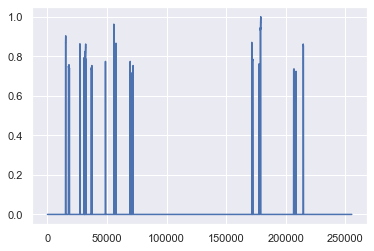

In [24]:
plt.close()
plt.plot(signal_values[210][3])

In [25]:
signal_values

[(1024, 0, 8, array([1., 1., 1., ..., 1., 1., 1.])),
 (1024, 4, 8, array([1., 1., 1., ..., 1., 1., 1.])),
 (1024, 8, 8, array([0., 0., 0., ..., 0., 0., 0.])),
 (1024, 12, 8, array([0., 0., 0., ..., 0., 0., 0.])),
 (1024, 16, 8, array([0., 0., 0., ..., 0., 0., 0.])),
 (1024, 20, 8, array([0., 0., 0., ..., 0., 0., 0.])),
 (1024, 24, 8, array([0., 0., 0., ..., 0., 0., 0.])),
 (1024, 28, 8, array([0., 0., 0., ..., 1., 1., 1.])),
 (1024,
  32,
  8,
  array([0.00995025, 0.00995025, 0.00995025, ..., 1.        , 1.        ,
         1.        ])),
 (1024,
  36,
  8,
  array([0.15294118, 0.15294118, 0.15294118, ..., 0.62352941, 0.62352941,
         0.62352941])),
 (1024,
  40,
  8,
  array([0.44313725, 0.44313725, 0.44313725, ..., 0.98823529, 0.99215686,
         0.99215686])),
 (1024,
  44,
  8,
  array([0.06666667, 0.06666667, 0.06666667, ..., 0.8       , 0.86666667,
         0.86666667])),
 (1024, 48, 8, array([0., 0., 0., ..., 0., 0., 0.])),
 (1024,
  52,
  8,
  array([0.33333333, 0.3333333

In [26]:
pd_csv = pd.read_csv(csv_paths_honda[0])

## Run the rest of these cells. They graph the signals of interest based on the scores given by the LSTM. 

This has allowed us to find longitudinal radar signals (verified with webcam), latitudinal radar signals (still need verification), and relative velocity (verified using comparison to derivative of longitudinal radar signals). 

More verification is necessary, but the graphs below demonstrate a high likelihood of these signal labels being correct.

Text(0, 0.5, 'Value')

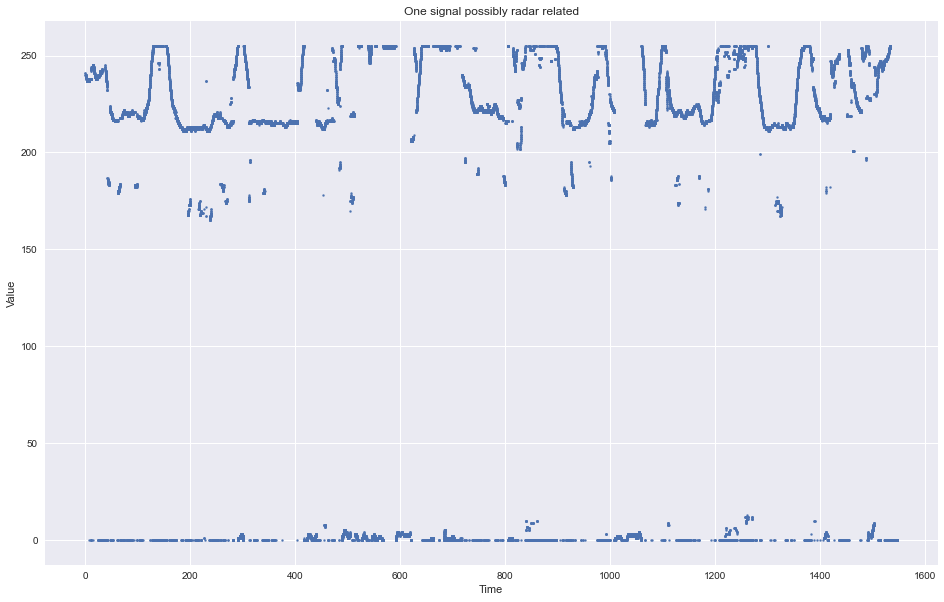

In [24]:
plt.close()
plt.figure(figsize=(16, 10))
plt.title("One signal possibly radar related")
signal_index, signal_value = plot_message_id(pd_csv, 1040, 24, 8, byteorder='big', signed=False, scale=1, offset=0, plot_fxn=None)

plt.scatter(signal_index[0].values - signal_index[0].values[0], signal_value[0].values, s=4)
# plt.legend(loc='middle right')
plt.xlabel("Time")
plt.ylabel("Value")

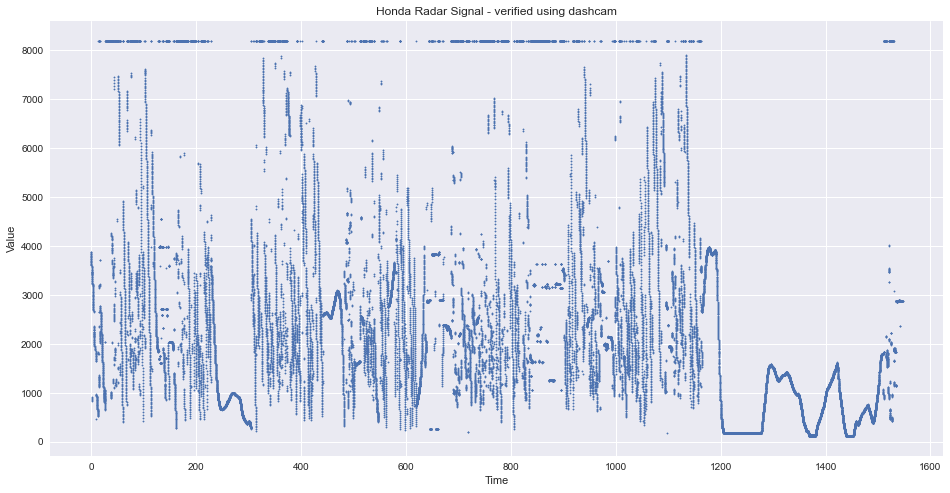

In [21]:
pd_csv = pd.read_csv(csv_paths_honda[1])

plt.close()
plt.title("Honda Radar Signal - verified using dashcam")
signal_index, signal_value = plot_message_id(pd_csv, 1043, 0, 13, byteorder='big', signed=False, scale=1, offset=0, plot_fxn=None)

plt.scatter(signal_index[0].values - signal_index[0].values[0], signal_value[0].values, s=2)
# plt.legend(loc='middle right')
plt.xlabel("Time")
plt.ylabel("Value")

long_signal_index, long_signal_value = signal_index, signal_value

Text(0, 0.5, 'Value')

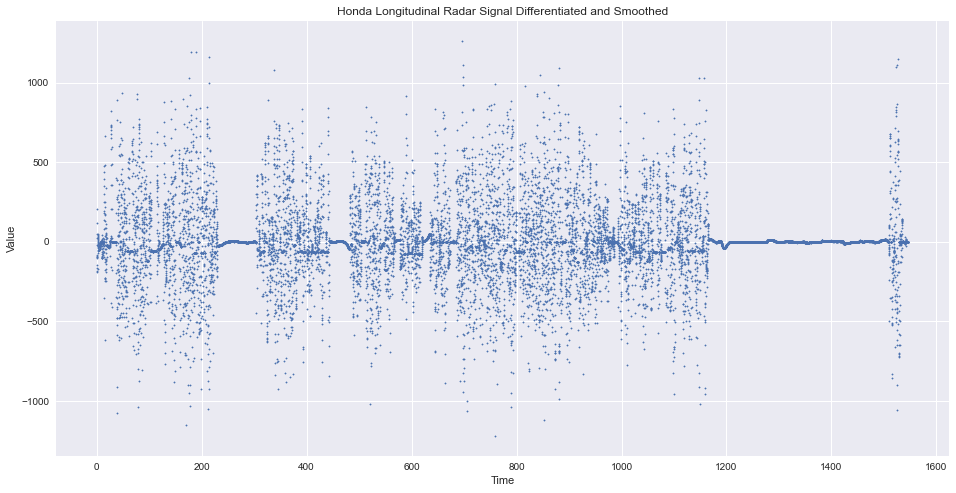

In [22]:
from scipy import interpolate

diff = np.diff(signal_value[0].values)

f = interpolate.interp1d(long_signal_index[0].values, long_signal_value[0].values, kind='nearest')
new_index = np.arange(long_signal_index[0].values[0], long_signal_index[0].values[-1], 0.1)
new_values = np.array(f(new_index))

diff = np.diff(new_values)

from scipy.signal import savgol_filter

diff_new = savgol_filter(diff, 21, 3)

plt.close()
plt.title("Honda Longitudinal Radar Signal Differentiated and Smoothed")
plt.scatter((new_index - new_index[0])[1:], diff_new, s=2)
# plt.legend(loc='middle right')
plt.xlabel("Time")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

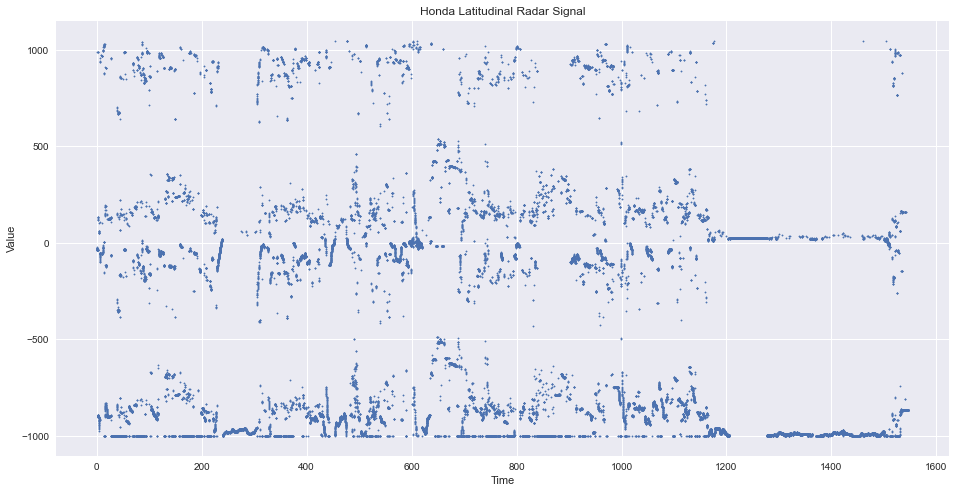

In [23]:
pd_csv = pd.read_csv(csv_paths_honda[1])

plt.close()
plt.title("Honda Latitudinal Radar Signal")
signal_index, signal_value = plot_message_id(pd_csv, 1043, 13, 11, byteorder='big', signed=False, scale=1, offset=-1000, plot_fxn=None)

plt.scatter(signal_index[0].values - signal_index[0].values[0], signal_value[0].values, s=2)
# plt.legend(loc='middle right')
plt.xlabel("Time")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

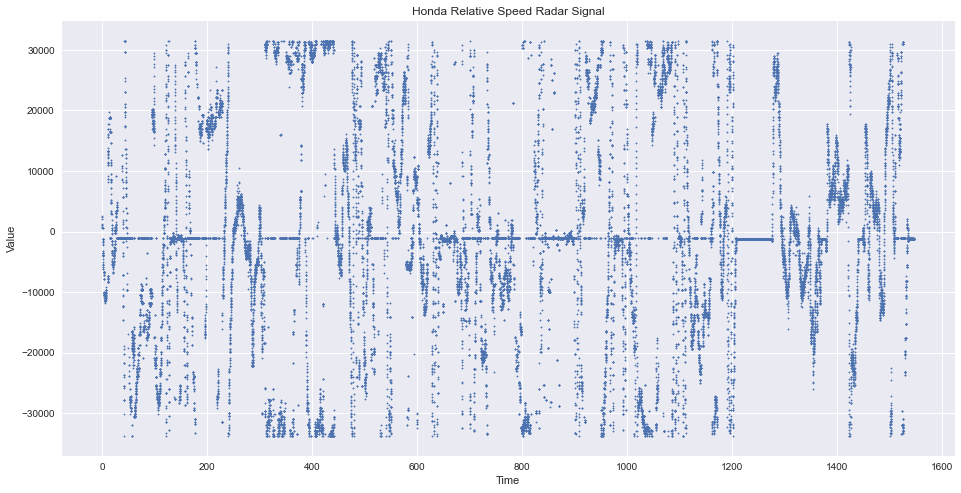

In [25]:
pd_csv = pd.read_csv(csv_paths_honda[1])

plt.close()
plt.title("Honda Relative Speed Radar Signal")
signal_index, signal_value = plot_message_id(pd_csv, 1043, 24, 12, byteorder='little', signed=True, scale=1, offset=-1000, plot_fxn=None)

plt.scatter(signal_index[0].values - signal_index[0].values[0], signal_value[0].values, s=2)
# plt.legend(loc='middle right')
plt.xlabel("Time")
plt.ylabel("Value")

In [26]:
f_radar_speed = interpolate.interp1d(signal_index[0].values, signal_value[0].values, kind='nearest')
new_values = np.array(f_radar_speed(new_index))

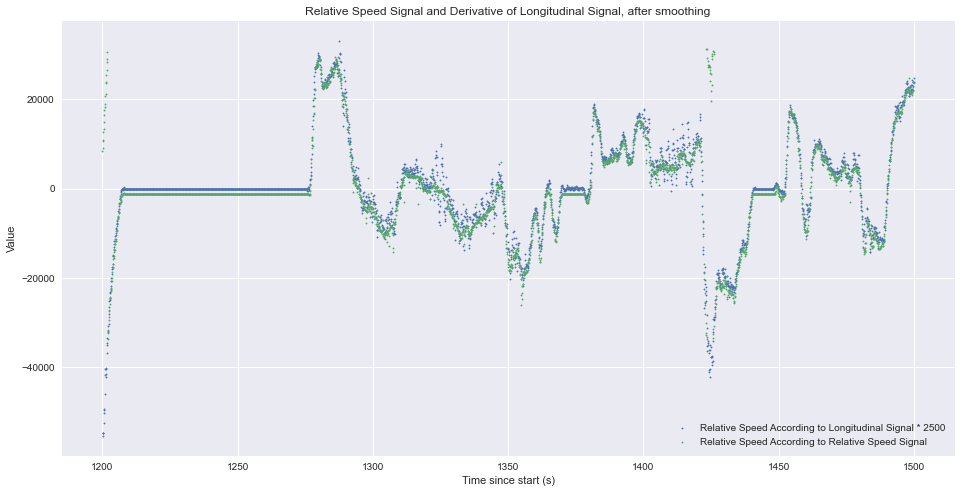

In [28]:
plt.close()
plt.title("Relative Speed Signal and Derivative of Longitudinal Signal, after smoothing")
plt.scatter((new_index - new_index[0])[12001:15001], diff_new[12000:15000] * 2500, s=2, label="Relative Speed According to Longitudinal Signal * 2500")
plt.scatter((new_index - new_index[0])[12000:15000], new_values[12000:15000], s=2, label="Relative Speed According to Relative Speed Signal")
plt.ylabel("Value")
plt.xlabel("Time since start (s)")
plt.legend()
plt.show()

In [14]:
from scipy import stats

In [16]:
!pip install strym

Defaulting to user installation because normal site-packages is not writeable
  Using cached strym-0.4.13-py2.py3-none-any.whl (120 kB)
  Using cached sphinx_markdown_parser-0.2.4-py2.py3-none-any.whl (19 kB)
  Using cached webdriver_manager-3.5.2-py2.py3-none-any.whl (17 kB)
  Using cached nbsphinx-0.8.8-py3-none-any.whl (25 kB)
  Using cached plotly-4.12.0-py2.py3-none-any.whl (13.1 MB)
  Using cached gmplot-1.4.1-py3-none-any.whl (164 kB)
  Using cached pymdown_extensions-9.1-py3-none-any.whl (215 kB)
  Using cached sphinx_rtd_theme-1.0.0-py2.py3-none-any.whl (2.8 MB)
  Using cached gmaps-0.9.0.tar.gz (1.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached recommonmark-0.7.1-py2.py3-none-any.whl (10 kB)
  Using cached bokeh-2.4.2-py3-none-any.whl (18.5 MB)
  Using cached scikit_learn-1.0.2-cp38-cp38-win_amd64.whl (7.2 MB)
  Using cached sphinxcontrib-fulltoc-1.2.0.tar.gz (13 kB)
  Preparing metadata (setup.py): st

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

INFO: pip is looking at multiple versions of sphinx-rtd-theme to determine which version is compatible with other requirements. This could take a while.
  Using cached sphinx_rtd_theme-0.5.2-py2.py3-none-any.whl (9.1 MB)
INFO: pip is looking at multiple versions of sphinx-markdown-parser to determine which version is compatible with other requirements. This could take a while.
  Using cached sphinx_markdown_parser-0.2.3-py2.py3-none-any.whl (18 kB)
INFO: pip is looking at multiple versions of sphinx-bootstrap-theme to determine which version is compatible with other requirements. This could take a while.
  Using cached sphinx-bootstrap-theme-0.7.1.tar.gz (1.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of setuptools-scm to determine which version is compatible with other requirements. This could take a while.
  Using cached setuptools_scm-6.4.1-py3-none-any.whl (37 kB)
INFO: pip is l

In [18]:
from strym import strymread

smoothed_diff = strymread.denoise(pd.DataFrame({'Time': (new_index - new_index[0])[12001:15001], 'Message': diff_new[12000:15000]}))
smoothed_radar = strymread.denoise(pd.DataFrame({'Time': (new_index - new_index[0])[12000:15000], 'Message': new_values[12000:15000]}))

smoothed_diff = strymread.denoise(smoothed_diff)
smoothed_radar = strymread.denoise(smoothed_radar)

stats.pearsonr(smoothed_diff['Message'], smoothed_radar['Message']), stats.pearsonr(diff_new[12000:15000], new_values[12000:15000])

((0.7190983000970657, 0.0), (0.7296075142382974, 0.0))